In [1]:
using FEM, Potential, AlphaBeta, PyPlot, Printf, PhotonOperator, JLD, LinearAlgebra

┌ Info: Precompiling AlphaBeta [d77d55e1-23be-40c5-8652-b23c35d89ba5]
└ @ Base loading.jl:1278


### Part 1: Get collocation points and integration kernel for whole domain

In [2]:
Nh = 64    # The number of Spectral element
Np = 4     # The order of polynomial which used to interpolate and integration
Nv = 72    # Number of eigenvectors

# Define Physical Domain
xratio = 1. # unit: angstrom
xavg = 1.   # unit: angstrom

x, w, Ldx, L = getLagrange(Np, xratio/Nh)
e_norm = x[end] - x[1]
interpo_xs = x .+ x[end]

N, xref, w0, Ldx, w = get_fem_xref_weights_basis(Nh, Np, xratio, xavg);

### Part 2: Set $V_{eq}(x)$ and $p_{eq}(x)$

In [3]:
k_ref = 247.15 # unit: dimensionless
Vref = harmonic_well_k_mean(xref, k_ref, xavg)
rho_eq = get_rhoeq(Vref, w0);

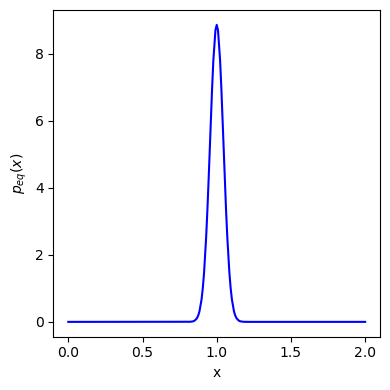

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(4,4))
ax.plot(xref, rho_eq .* rho_eq, color="blue")
ax.set_xlabel("x")
ax.set_ylabel("\$ p_{eq}(x) \$")
plt.tight_layout()
plt.show()

### Part 3: Set the force constant($\sigma$ of Gaussian) of Photon Operator

In [4]:
## Photon Operator
k_photon = 5000. # unit: kcal/mol/angstrom^2
sigma_photon = 1 / sqrt(2 * k_photon);

### Part 4: Read Trajectory

#### physical parameters about simulations

In [5]:
save_freq = 1e-3 # unit: s, Save trajectory per 10e-3 s
total_times = 10 # unit: s, totol simulate 10 s
dt = 1e-5 # unit: s  # Integration Times 1ps
#kbT = 1
tau = Int(round(total_times / save_freq, digits=0))  # Number of photons
n_interval = Int(round(save_freq / dt, digits=0));

time_info = @sprintf "Save trajectory per %d timesteps. There will be %d data points." n_interval tau
println(time_info)

Save trajectory per 100 timesteps. There will be 10000 data points.


#### read simulated trajectory from jld file

In [6]:
# Read simulated trajectory from jld file
f_in = "/home/yizaochen/codes/julia/md_pisl/trajectory/harmonic_dimensionless.jld"
y_record = load(f_in, "y_record")
t_record = load(f_in, "t_record")
xref = load(f_in, "xref")
rho_eq = load(f_in, "rho_eq")
k_ref = load(f_in, "k_ref")
D = load(f_in, "D");

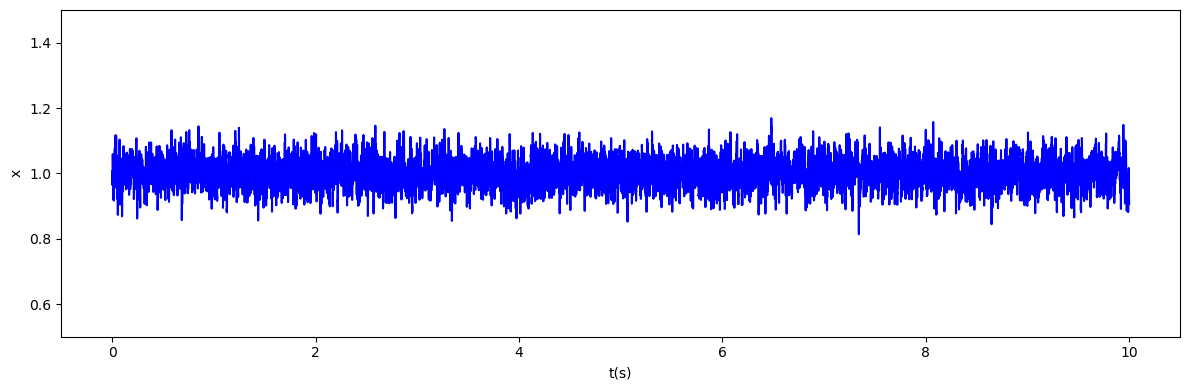

In [10]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12,4))
ax.plot(t_record, y_record, color="blue")
ax.set_xlabel("t(s)")
ax.set_ylabel("x")
ax.set_ylim(0.5, 1.5)
#ax.set_title("Model 1")
plt.tight_layout()
plt.show()

### Part 5: Complete EM

Set number of iteration and output file name

In [7]:
max_n_iteration = 30
f_out_pcontain = "/home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well.jld"
f_out_d_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well.jld"
f_out_l_record = "/home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well.jld";

In [8]:
k_kde = 50.0
D_init = 1.0
p_container, D_records, log_likelihood_records = complete_em_v0(max_n_iteration, N, Nh, Np, xratio, xavg, Nv, tau, y_record, 
    save_freq, xref, e_norm, w0, f_out_pcontain, f_out_d_record, f_out_l_record, k_photon, k_kde, D_init);

Iteration-ID: 1
Iteration-ID: 2
Iteration-ID: 3
Iteration-ID: 4
Iteration-ID: 5
Iteration-ID: 6
Converged....EM Done.
Write p_container to /home/yizaochen/codes/julia/md_pisl/EM_data/peq_harmonic_well.jld
Write D_records to /home/yizaochen/codes/julia/md_pisl/EM_data/D_harmonic_well.jld
Write log_likelihood_records to /home/yizaochen/codes/julia/md_pisl/EM_data/l_harmonic_well.jld


### Part 6: Plots

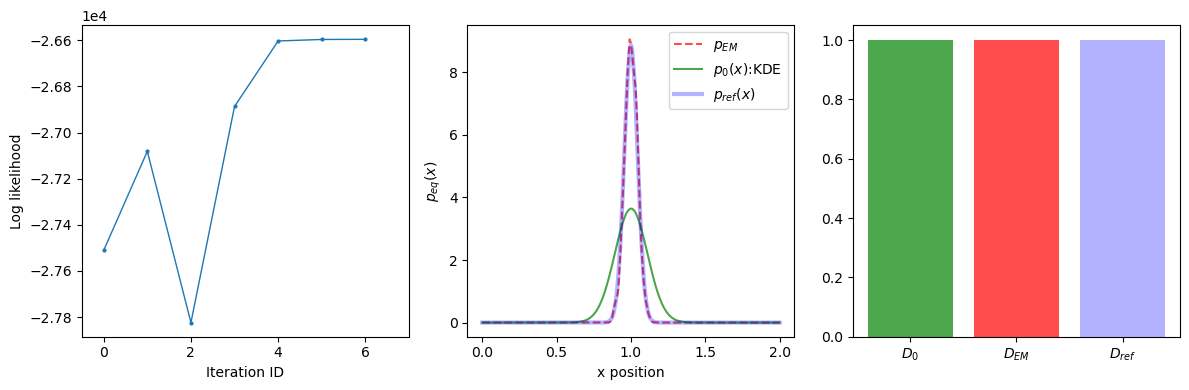

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,4))

lastem_id = 6

ax = axes[1]
xarray = 0:lastem_id
ax.plot(xarray, log_likelihood_records[1:lastem_id+1], "-o", linewidth=1, markersize=2)
ax.set_xlabel("Iteration ID")
ax.set_ylabel("Log likelihood")
ax.set_xlim(-0.5, lastem_id+1)
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
#title = @sprintf "Converge at iteration %d" lastem_id
#ax.set_title(title)

ax = axes[2]
ax.plot(xref, p_container[lastem_id+1, :], "--", color="red", alpha=0.7, label="\$p_{EM}\$")
ax.plot(xref, p_container[1,:], label="\$ p_0(x) \$:KDE", alpha=0.7, color="green")
ax.plot(xref, rho_eq .* rho_eq, linewidth=3, color="blue", alpha=0.3, label="\$ p_{ref}(x) \$")
#for xline in 30:5:70
#    ax.axvline(xline, color="grey", alpha=0.2)
#end
ax.legend()
ax.set_xlabel("x position")
ax.set_ylabel("\$ p_{eq}(x) \$")

ax = axes[3]
xarray = [1, 2, 3]
label1 = @sprintf "%.3E" D_records[1]
label2 = @sprintf "%.3E" D_records[lastem_id+1]
label3 = @sprintf "%.3E" D
ax.bar(1, D_records[1], color="green", alpha=0.7, label=label1)
ax.bar(2, D_records[lastem_id+1], color="red", alpha=0.7, label=label2)
ax.bar(3, D, color="blue", alpha=0.3, label=label3)
ax.set_xticks(xarray)
ax.set_xticklabels(["\$D_0\$", "\$D_{EM}\$", "\$D_{ref}\$"])
#ax.set_ylim(4.5e9, 4.9e9)
#ax.set_yticks([0e9,1e9,2e9,3e9,4e9,D_records[1]])

plt.tight_layout()
svgfile = "./em_p0_kde_pref_gmm_triplewell_2.pdf"
#plt.savefig(svgfile)
plt.show()

### Addtional Part: Gaussian kernel estimator for $r(x)$
\begin{equation}
\hat{r}(x) = \frac{1}{T} \sum_{i=1}^{N} \Delta t_i k(x;\alpha^2)
\end{equation}
where $\alpha=1$

In [22]:
k_kde = 50 # 0.05 # unit: kcal/mol/angstrom^2
σ = 1 / sqrt(2 * k_kde)
r_hat = gaussian_kde(xref, y_record, σ, w0);

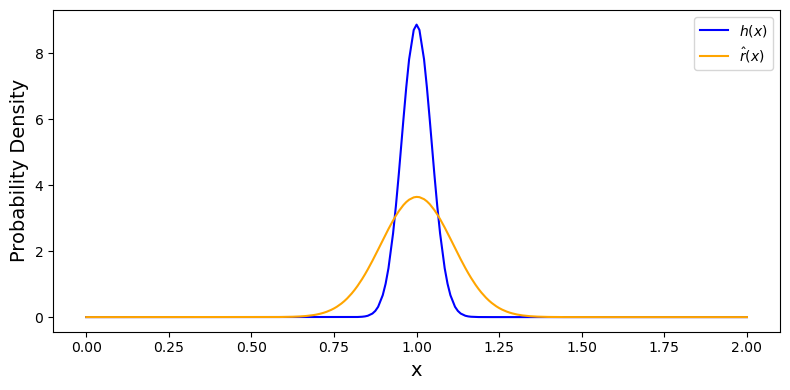

In [23]:
lbfz = 14
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(8,4))

ax.plot(xref, rho_eq .* rho_eq, color="blue", label="\$h(x)\$")
ax.plot(xref, r_hat, color="orange", label="\$\\hat{r}(x)\$")
ax.set_ylabel("Probability Density", fontsize=lbfz)
ax.set_xlabel("x", fontsize=lbfz)
ax.legend()
#ax.set_ylim(30,70)

plt.tight_layout()
plt.show()